In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

for density 
* generate lenstronomy lens at a given pixel density
* start timer
* convert that to pandeia input
* run pandeia
* save figure
* stop time
* record time

In [2]:
import sys
import os
import json

from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import numpy as np
from astropy.wcs import WCS
from astropy.table import Table
import astropy.wcs.utils

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import get_telescope_config, get_instrument_config, build_default_calc, build_default_source
from pandeia.engine.io_utils import read_json, write_json

import math
import time

from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()

from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF

In [ ]:
oversample_factor_list = [1, 3, 5, 7, 9]
execution_time = []

In [ ]:
# mass model
lens_model_list = ['SIE', 'SHEAR']
kwargs_spemd = {'theta_E': 1.7, 'e1': 0.07, 'e2': -0.03, 'center_x': 0.05, 'center_y': -0.25}
kwargs_shear = {'gamma1': 0.1, 'gamma2': -0.05}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list)

# light model
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic_lens = {'amp': 10, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(lens_light_model_list)

# source model
source_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic = {'amp': 10, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
kwargs_source_light = [kwargs_sersic]
source_model_class = LightModel(source_model_list)

kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'source_light_model_list': source_model_list}

kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

kwargs_numerics = {'supersampling_factor': 4,
                'supersampling_convolution': False}

  0%|          | 0/5 [00:00<?, ?it/s]

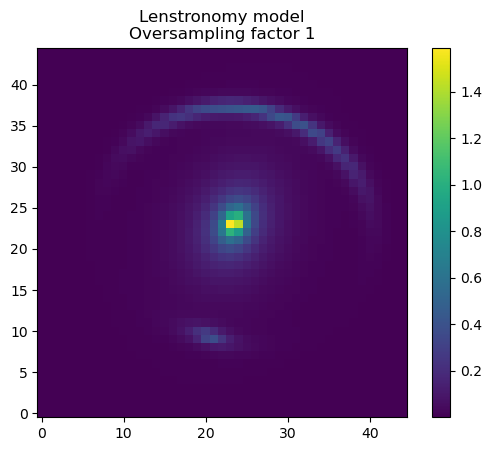

 20%|██        | 1/5 [00:00<00:01,  3.62it/s]

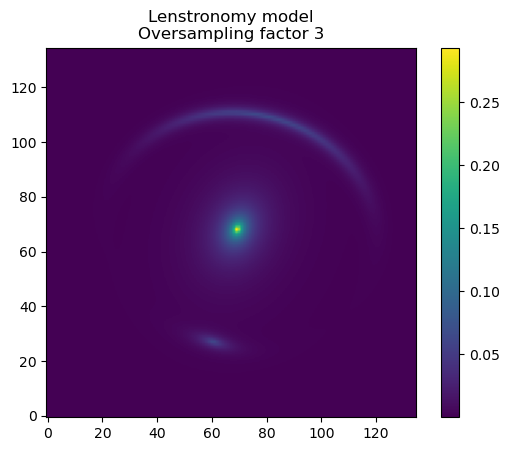

 40%|████      | 2/5 [00:00<00:00,  3.13it/s]

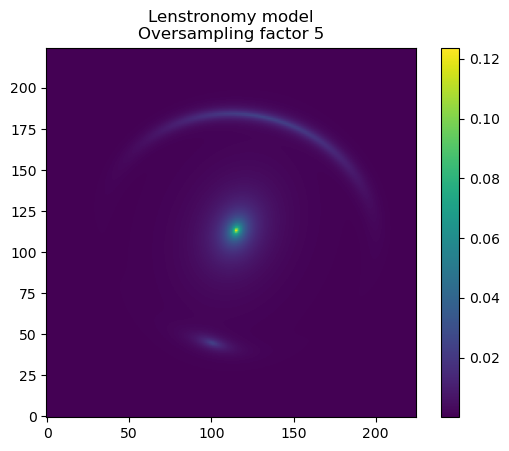

 60%|██████    | 3/5 [00:01<00:00,  2.28it/s]

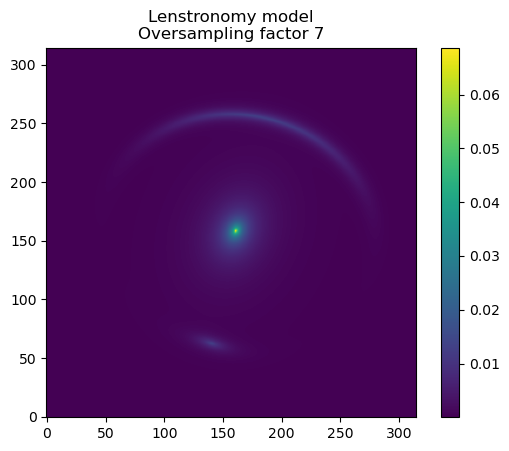

 80%|████████  | 4/5 [00:02<00:00,  1.60it/s]

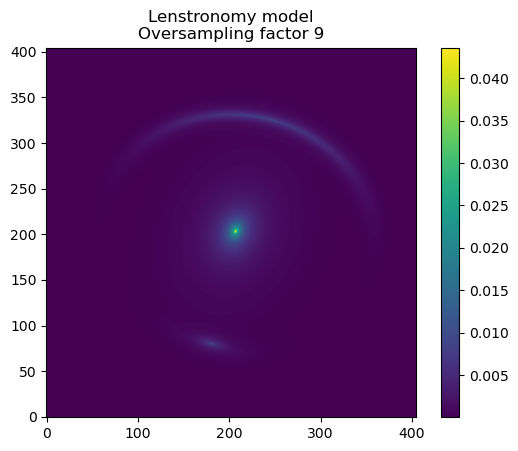

100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


In [5]:
for oversample_factor in tqdm(oversample_factor_list):
    side = 5  # arcseconds
    num_pix = 45 * oversample_factor
    delta_pix = side / num_pix  # size of pixel in angular coordinates

    ra_at_xy_0, dec_at_xy_0 = -delta_pix * math.ceil(num_pix / 2), -delta_pix * math.ceil(num_pix / 2) # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
    transform_pix2angle = np.array([[1, 0], [0, 1]]) * delta_pix  # linear translation matrix of a shift in pixel in a shift in coordinates

    kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                    'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                    'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                    'transform_pix2angle': transform_pix2angle}
    pixel_grid = PixelGrid(**kwargs_pixel)

    imageModel = ImageModel(data_class=pixel_grid,
                            psf_class=psf_class,
                            lens_model_class=lens_model_class,
                            source_model_class=source_model_class,
                            lens_light_model_class=lens_light_model_class,
                            kwargs_numerics=kwargs_numerics)

    image = imageModel.image(kwargs_lens=kwargs_lens,
                            kwargs_source=kwargs_source_light,
                            kwargs_lens_light=kwargs_lens_light)

    plt.imshow(image)
    plt.title('Lenstronomy model\nOversampling factor ' + str(oversample_factor))
    # plt.savefig(os.path.join('figures', 'pixel_density_test', 'model_' + str(oversample_factor) + '.png'))
    plt.colorbar()
    plt.show()